# 2c. Satellite featurizations part 3 -- Satellite-related figures and tables

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import config
import time
import seaborn as sns
from sklearn.decomposition import PCA
from numba import jit


### Table S1: Summary of datasets

In [27]:
TILES_FOLDER = '/data/mosaiks/replication/sampled_tiles/'

save_fig = False
fig_dir = 'figs/fairsiml_figs'

In [29]:
table = []

for country in ['mexico', 'dhs/colombia', 'dhs/honduras', 'dhs/indonesia', 'dhs/kenya', 'dhs/nigeria', 
                'dhs/peru','dhs/philippines', 'india', 'us',]: #'india']:
    
    if country == 'mexico':
        survey = pd.read_csv('/data/mosaiks/replication/surveys/' + country + '/grouped.csv')
        meta = pd.read_csv(TILES_FOLDER + country + '/meta.csv')
    elif country == 'india':
        survey = pd.read_csv('/data/mosaiks/replication/surveys/' + country + '/grouped.csv')
        meta = pd.read_csv(TILES_FOLDER + country + '/shrug_condensed_regions_25_max_tiles_100_meta.csv')
    elif country == 'us':
        survey = pd.read_csv('/data/mosaiks/replication/surveys/' + country + '/groundtruth_by_puma_2019.csv')
        meta = # TODO EMILY
    else:
        survey = pd.read_csv('/data/mosaiks/replication/surveys/' + country + '_grouped.csv')
        meta = pd.read_csv(TILES_FOLDER + country + '/meta.csv')
        
        
    table.append([country, len(survey), '%.2f' % (100*survey['rural'].mean()), meta['count'].min(), 
                  '%.2f' % meta['count'].mean(), meta['count'].max()])
table = pd.DataFrame(table)
table.columns = ['Country', 'Regions', '% Rural', 'Min. Tiles', 'Mean Tiles', 'Max Tiles']
table

/data/tmp/ipykernel_1014034/655247961.py:10: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  survey = pd.read_csv('/data/mosaiks/replication/surveys/' + country + '/grouped.csv')


FileNotFoundError: [Errno 2] No such file or directory: '/data/mosaiks/replication/surveys/us_grouped.csv'

### Figure 2

In [4]:
# plot average dist by urban and rural

def barplot_dists(mean_dfs, stderr_dfs, all_country_names, ax = None,
                 title='average distance between pairs of MOSAIKS features'):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,6))
        
    n_countries = len(all_country_names)

    ax.bar(np.arange(n_countries)-.25, mean_dfs['Rural-Rural'], label= 'Rural-Rural', color='indianred', width = 0.2)
    ax.bar(np.arange(n_countries), mean_dfs['Urban-Urban'], label= 'Urban-Urban', color='steelblue', width = 0.2)
    ax.bar(np.arange(n_countries)+.25, mean_dfs['Urban-Rural'], label= 'Urban-Rural',color='yellowgreen', width = 0.2)

    ax.errorbar(np.arange(n_countries)-.25, mean_dfs['Rural-Rural'], 
                yerr=2*stderr_dfs['Rural-Rural'], fmt="none", color="black",capsize=2)
    ax.errorbar(np.arange(n_countries), mean_dfs['Urban-Urban'], 
                yerr=2*stderr_dfs['Urban-Urban'], fmt="none", color="black",capsize=2)
    ax.errorbar(np.arange(n_countries)+.25, mean_dfs['Urban-Rural'], 
               yerr=2*stderr_dfs['Urban-Rural'], fmt="none", color="black",capsize=2)


    ax.legend(fontsize=12)
    ax.set_xticks(np.arange(n_countries)+.2)
    ax.set_xticklabels([x.title() for x in all_country_names], rotation=30, ha='right')
    ax.set_ylabel(r'avg. $\ell_2$ distance ')
    ax.set_title(title)
    return ax

def clean_plot(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    plt.tight_layout
    
@jit
def slow_dist(X):
    out = np.zeros((X.shape[0],X.shape[0]))
    
    for i in range(len(X)):
        for j in range(i+1,len(X)):
            dist = np.sqrt(np.sum((X[i] - X[j])**2))
            out[i,j] = dist
            out[j,i] = dist
    
    return out


In [5]:
cfg = config.dataset_keys

In [ ]:
explained_variance_ratios = []
dists_by_urban_rural_all = []

pcas = []
rurals = []

dhs_country_names = ['colombia', 
                             'honduras', 
                             'indonesia', 
                             'nigeria', 
                             'kenya', 
                             'peru', 
                             'philippines']

other_country_names = ['US','Mexico', 'India']

all_country_names = np.sort([x.lower() for x in dhs_country_names + other_country_names])
print(all_country_names)


for c,country in enumerate(all_country_names):
    
    # 1. read in data
    if country.lower() in ['us', 'mexico', 'india_nl', 'india']:
        cfg_this = cfg[country.lower()]
        features_fname = cfg_this['FEATURES_FNAME']
        labels_fname = cfg_this['LABELS_FNAME']
    else:   
        cfg_this = cfg['dhs']
        features_fname = cfg_this['FEATURES_FNAME'](country)
        labels_fname = cfg_this['LABELS_FNAME'](country)
    
    merge_keys = cfg_this['MERGE_KEYS']
    pov_key = cfg_this['POVERTY']
    print(features_fname)
    
    feats_df = pd.read_csv(features_fname)
    rural_df = pd.read_csv(labels_fname, low_memory=False)[merge_keys+['rural',pov_key]]
    df = pd.merge(feats_df, rural_df, how='inner', on=merge_keys)

    # subset india because it's so big
    # note: this means India will look different each time in this plot
    if country.lower() == 'india':
        n_instances_per_group_india = 2000
        df = df.groupby('rural', group_keys=False).apply(lambda x: x.sample(n_instances_per_group_india, 
                                                                            replace=False))

        
    nfeats = 4000
    feat_cols = [f'Feature{x}' for x in range(nfeats)]
    pov = df[pov_key]

    X = np.array(df.loc[:,feat_cols])
    rural = np.array(df['rural']).astype(int)
    
    # 2. compute distance between all points
    t1 = time.time()
    dists = slow_dist(X)
    t2 = time.time()
    print(f'{t2-t1:.2f} seconds')
    
    # 3. average distances by urban and rural
    dists_by_urban_rural = {'00':[],
                            '01':[],
                            '10':[],
                            '11':[]}
    
    # count all pairs
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            ur_key = f'{rural[i]}{rural[j]}'
            dists_by_urban_rural[ur_key].append(dists[i,j])
    
    # urban rural pairs are e
    dists_ur = {'rural_rural': dists_by_urban_rural['11'],
                'urban_urban': dists_by_urban_rural['00'],
                'mixed': dists_by_urban_rural['01'] + dists_by_urban_rural['10']
               }
    
    dists_by_urban_rural_all.append(dists_ur)
    

    print(country)
 
    # plot pca dimension reduction by urban rural
    pca = PCA(n_components=2)
    X_pca_2 = pca.fit_transform(X)
    pcas.append(X_pca_2)
    rurals.append(rural)
    explained_variance_ratios.append(pca.explained_variance_ratio_)


['colombia' 'honduras' 'india' 'indonesia' 'kenya' 'mexico' 'nigeria'
 'peru' 'philippines' 'us']
/data/mosaiks/replication/features/dhs/mosaiks_features_by_cluster_colombia.csv
302.39 seconds
colombia
/data/mosaiks/replication/features/dhs/mosaiks_features_by_cluster_honduras.csv
13.96 seconds
honduras
/data/mosaiks/replication/features/mosaiks_features_by_shrug_condensed_regions_25_max_tiles_100_india.csv
423.91 seconds
india
/data/mosaiks/replication/features/dhs/mosaiks_features_by_cluster_indonesia.csv
34.74 seconds
indonesia
/data/mosaiks/replication/features/dhs/mosaiks_features_by_cluster_kenya.csv
54.12 seconds
kenya
/data/mosaiks/replication/features//mosaiks_features_by_municipality_mexico.csv
149.38 seconds
mexico
/data/mosaiks/replication/features/dhs/mosaiks_features_by_cluster_nigeria.csv
38.88 seconds
nigeria
/data/mosaiks/replication/features/dhs/mosaiks_features_by_cluster_peru.csv
24.05 seconds
peru
/data/mosaiks/replication/features/dhs/mosaiks_features_by_cluster_p

In [16]:
cols = ['Country', 'Rural-Rural', 'Urban-Urban','Urban-Rural']
mean_dfs = []
stderr_dfs = []

def compute_se(x):
    return np.std(x) / np.sqrt(len(x))

for c,country in enumerate(all_country_names):
    mean_dfs.append(pd.DataFrame([[country.capitalize(),
                              np.mean(dists_by_urban_rural_all[c]['rural_rural']),
                              np.mean(dists_by_urban_rural_all[c]['urban_urban']),
                              np.mean(dists_by_urban_rural_all[c]['mixed']),
                                                ]],
                           columns = cols))
    
    stderr_dfs.append(pd.DataFrame([[country.capitalize(),
                                      compute_se(dists_by_urban_rural_all[c]['rural_rural']),
                                      compute_se(dists_by_urban_rural_all[c]['urban_urban']),
                                      compute_se(dists_by_urban_rural_all[c]['mixed']),
                                                ]],
                           columns = cols))
    
mean_dfs_all = pd.concat(mean_dfs).sort_values(by='Country')
stderr_dfs_all = pd.concat(stderr_dfs).sort_values(by='Country')


### Figure 2

In [17]:
def co_shuffle_instances(to_shuffle, seed=0):
    rs = np.random.RandomState(0)
    n = len(to_shuffle[0])
    idxs = rs.choice(n,n,replace=False)
    
    return [x[idxs] for x in to_shuffle]



def plot_pca(X_pca, 
             rurals, 
             palette = {0: 'steelblue', 1:'indianred'},
             kwargs = {'alpha':0.4},
             ax=None):

    if ax is None:
        fig, ax = plt.subplots()
        
    ax.scatter(X_pca[:,0],X_pca[:,1],
               c=[palette[x] for x in rurals],
               **kwargs)
    


In [18]:
all_country_names = [str(x) for x in all_country_names]
all_country_names[-1] = 'united states'


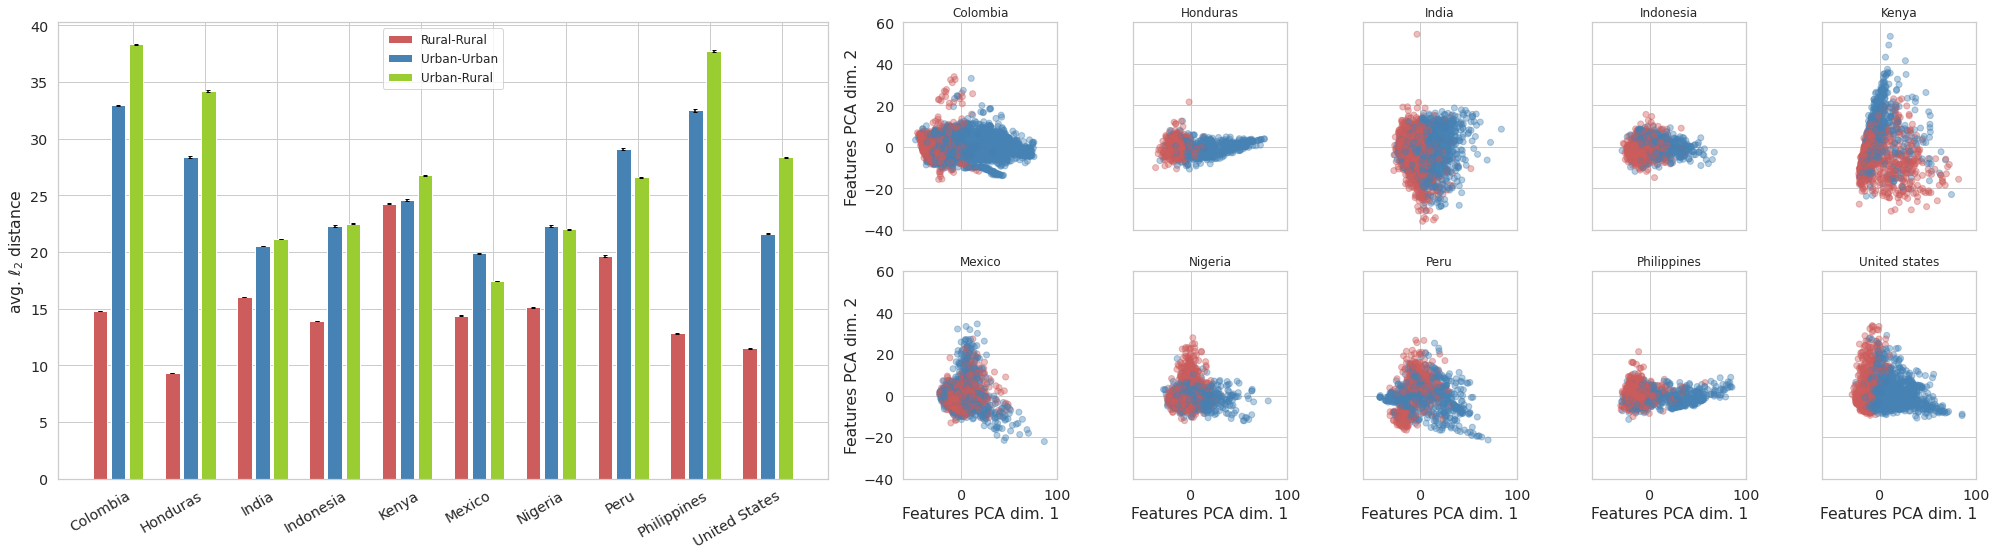

In [20]:
sns.set(font_scale=1.3, style='whitegrid')


gs_kw = dict(width_ratios=[5,] + [1]*5,height_ratios = [1,1])
figsize = (28, 8)
fig, axd = plt.subplot_mosaic([['barplot',] + [f'pca_{i}' for i in range(5)],
                               ['barplot',] + [f'pca_{i}' for i in range(5,10)]],
                               gridspec_kw=gs_kw,
                               figsize=figsize,)


barplot_dists(mean_dfs_all, stderr_dfs_all, all_country_names=all_country_names, 
              ax=axd['barplot'],
              title=None
              #r'$\bf{(A)}$ average distance between pairs of MOSAIKS features'
             )

for c,country in enumerate(all_country_names): 
    axc = axd[f'pca_{c}']    
    [X_pca_shuffled, rurals_shuffled] = co_shuffle_instances([pcas[c],rurals[c]])
    
    plot_pca(X_pca_shuffled, rurals_shuffled, ax=axc)


for c in range(len(all_country_names)):
    axc = axd[f'pca_{c}']
    if c % 5 != 0:
        axc.set_yticklabels('')
    if c < 5:
        axc.set_xticklabels('')
        
    if c % 5 == 0: 
        axc.set_ylabel('Features PCA dim. 2')
        axd['pca_0'].set_ylabel('Features PCA dim. 2') 
    
    if c >= 5:
        axc.set_xlabel('Features PCA dim. 1')
        
    axc.set_xlim(-60,100)
    axc.set_ylim(-40,60)
    
    axc.set_title(all_country_names[c].capitalize(), fontsize=12)
    
fig.tight_layout()

if save_fig:
    plt.savefig(f'{fig_dir}/Figure_2.png',dpi=500, bbox_inches="tight")

In [21]:
print(np.array(explained_variance_ratios).sum(axis=1).min().round(3))
print(np.array(explained_variance_ratios).sum(axis=1).max().round(3))

0.933
0.985


### Figure S1

In [22]:
dhs_countries = ['colombia',  'honduras', 'indonesia', 'nigeria', 'kenya', 'peru', 'philippines']
all_countries = np.sort(dhs_countries + ['us', 'mexico', 'india'])
countries_one_tile = all_countries

In [23]:
countries_one_tile = all_countries
dists_by_urban_rural_all_one_tile = []
rurals_one_tile = []

for c,country in enumerate(countries_one_tile):
    
    
    # 1. read in data
    if country.lower() in ['us', 'mexico', 'india_nl', 'india']:
        cfg_this = cfg[country.lower()]
        features_fname = cfg_this['FEATURES_FNAME']
        labels_fname = cfg_this['LABELS_FNAME']
    else:   
        cfg_this = cfg['dhs']
        features_fname = cfg_this['FEATURES_FNAME'](country)
        labels_fname = cfg_this['LABELS_FNAME'](country)
    
    features_fname = features_fname.replace('features/','features_1_tile_per_region/')
    if 'india' in country.lower():
        features_fname = features_fname.replace('max_tiles_100','max_tiles_1')
    merge_keys = cfg_this['MERGE_KEYS']
    pov_key = cfg_this['POVERTY']
    print(features_fname)
    
    
    
    feats_df = pd.read_csv(features_fname)
    rural_df = pd.read_csv(labels_fname, low_memory=False)[merge_keys+['rural',pov_key]]
    
    df = pd.merge(feats_df, rural_df, how='inner', on=merge_keys)
    # subset india because it's so big
    if country.lower() == 'india':
        n_instances_per_group_india = 2000
        df = df.groupby('rural', group_keys=False).apply(lambda x: x.sample(n_instances_per_group_india, 
                                                                       replace=False))

    nfeats = 4000
    feat_cols = [f'Feature{x}' for x in range(nfeats)]
    pov = df[pov_key]

    X = np.array(df.loc[:,feat_cols])
    rural = np.array(df['rural']).astype(int)
    
    print(f'{country}: {len(df)} ({rural.sum()} rural), {len(rural)- rural.sum()} urban)')

    
    # 2. compute distance between all points
    t1 = time.time()
    dists = slow_dist(X)
    t2 = time.time()
    print(f'{t2-t1:.2f} seconds')
    
    # 3. average distances by urban and rural
    dists_by_urban_rural = {'00':[],
                            '01':[],
                            '10':[],
                            '11':[]}
    
    # count all pairs
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            ur_key = f'{rural[i]}{rural[j]}'
            dists_by_urban_rural[ur_key].append(dists[i,j])
            
    dists_ur = {'rural_rural': dists_by_urban_rural['11'],
                'urban_urban': dists_by_urban_rural['00'],
                'mixed': dists_by_urban_rural['01'] + dists_by_urban_rural['10']
               }
    
    dists_by_urban_rural_all_one_tile.append(dists_ur)
    rurals_one_tile.append(rural)

/data/mosaiks/replication/features_1_tile_per_region/dhs/mosaiks_features_by_cluster_colombia.csv
colombia: 4868 (1467 rural), 3401 urban)
691.27 seconds
/data/mosaiks/replication/features_1_tile_per_region/dhs/mosaiks_features_by_cluster_honduras.csv
honduras: 1128 (634 rural), 494 urban)
23.83 seconds
/data/mosaiks/replication/features_1_tile_per_region/mosaiks_features_by_shrug_condensed_regions_25_max_tiles_1_india.csv
india: 4000 (2000 rural), 2000 urban)
414.34 seconds
/data/mosaiks/replication/features_1_tile_per_region/dhs/mosaiks_features_by_cluster_indonesia.csv
indonesia: 1319 (762 rural), 557 urban)
34.66 seconds
/data/mosaiks/replication/features_1_tile_per_region/dhs/mosaiks_features_by_cluster_kenya.csv
kenya: 1585 (970 rural), 615 urban)
53.92 seconds
/data/mosaiks/replication/features_1_tile_per_region//mosaiks_features_by_municipality_mexico.csv
mexico: 2446 (1372 rural), 1074 urban)
149.50 seconds
/data/mosaiks/replication/features_1_tile_per_region/dhs/mosaiks_featu

In [24]:
cols = ['Country', 'Rural-Rural', 'Urban-Urban','Urban-Rural']
mean_dfs_1 = []
stderr_dfs_1 = []

def compute_se(x):
    return np.std(x) / np.sqrt(len(x))

for c,country in enumerate(countries_one_tile):
    mean_dfs_1.append(pd.DataFrame([[country.capitalize(),
                              np.mean(dists_by_urban_rural_all_one_tile[c]['rural_rural']),
                              np.mean(dists_by_urban_rural_all_one_tile[c]['urban_urban']),
                              np.mean(dists_by_urban_rural_all_one_tile[c]['mixed']),
                                                ]],
                           columns = cols))
    
    stderr_dfs_1.append(pd.DataFrame([[country.capitalize(),
                                      compute_se(dists_by_urban_rural_all_one_tile[c]['rural_rural']),
                                      compute_se(dists_by_urban_rural_all_one_tile[c]['urban_urban']),
                                      compute_se(dists_by_urban_rural_all_one_tile[c]['mixed']),
                                                ]],
                           columns = cols))
    
mean_dfs_1 = pd.concat(mean_dfs_1).sort_values(by='Country')
stderr_dfs_1 = pd.concat(stderr_dfs_1).sort_values(by='Country')

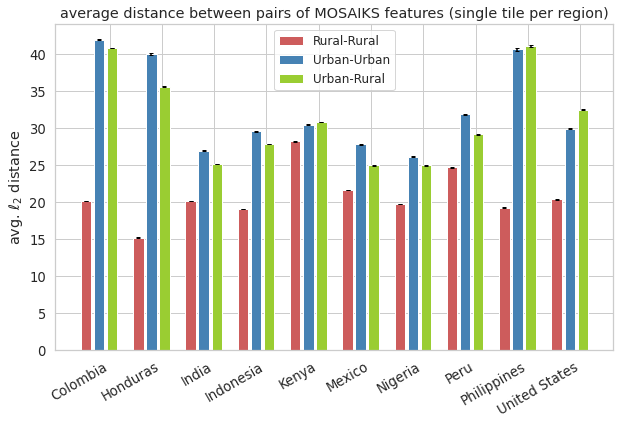

In [26]:
sns.set(font_scale=1.2, style='whitegrid')
fig, ax = plt.subplots(figsize=(10,6))
barplot_dists(mean_dfs_1, stderr_dfs_1, all_country_names=all_country_names, ax=ax)

ax.set_title('average distance between pairs of MOSAIKS features (single tile per region)')

if save_fig:
    plt.savefig(f'{fig_dir}/dist_between_feats_1_tile_per_region.png',dpi=500, bbox_inches="tight")